In [0]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

%matplotlib inline

In [0]:
class Deep3D(nn.Module):
    def __init__(self, fuse='sum', method='multi2'):
        super(Deep3D, self).__init__()
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1_1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc6 = nn.Linear(30720, 512)  
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout(p=0.5)

        self.fc7 = nn.Linear(512, 512)  
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout(p=0.5)

        self.fc8 = nn.Linear(512, 33*12*5)
        # rehape in forward to get pred5

        self.bn_pool4 = nn.BatchNorm2d(512)
        self.pred4 = nn.Conv2d(in_channels=512 ,out_channels=33, kernel_size=3 ,padding=1)
        self.bn_pool3 = nn.BatchNorm2d(256)
        self.pred3 = nn.Conv2d(in_channels=256 ,out_channels=33, kernel_size=3 ,padding=1)
        self.bn_pool2 = nn.BatchNorm2d(128)
        self.pred2 = nn.Conv2d(in_channels=128 ,out_channels=33, kernel_size=3 ,padding=1)
        self.bn_pool1 = nn.BatchNorm2d(64)
        self.pred1 = nn.Conv2d(in_channels=64 ,out_channels=33, kernel_size=3 ,padding=1)
        
        assert fuse == 'sum'
        assert method == 'multi2'
        workspace = 0
        scale = 1

        self.relu = nn.ReLU()

        self.deconv_pred1 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=1, padding=0, stride=1)
        scale *= 2

        self.deconv_pred2 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        scale *= 2

        self.deconv_pred3 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        scale *= 2

        self.deconv_pred4 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        scale *= 2

        self.deconv_pred5 = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        self.relu1 =  nn.ReLU()
        scale = 2
        self.deconv_predup = nn.ConvTranspose2d(in_channels=33, out_channels=33, kernel_size=2*scale, padding=scale//2, stride=scale)
        self.relu2 = nn.ReLU()
        self.convolution0 = nn.Conv2d(in_channels=33 ,out_channels=33, kernel_size=3 ,padding=1)

        self.softmax = nn.Softmax()

        # self.linear_closs = nn.Linear(hidden_sizes[5], feat_dim, bias=False)

    def forward(self, x, evalMode=False):
        out = x
        
        out = self.relu1_1(self.conv1_1(out))
        pool1 = self.pool1(out)

        out = self.relu2_1(self.conv2_1(pool1))
        pool2 = self.pool2(out)

        out = self.relu3_1(self.conv3_1(pool2))
        out = self.relu3_2(self.conv3_2(out))
        pool3 = self.pool3(out)

        out = self.relu4_1(self.conv4_1(pool3))
        out = self.relu4_2(self.conv4_2(out))
        pool4 = self.pool4(out)

        out = self.relu5_1(self.conv5_1(pool4))
        out = self.relu5_2(self.conv5_2(out))
        pool5 = self.pool5(out)

        out = self.flatten(pool5)

        out = self.drop6(self.relu6(self.fc6(out)))
        out = self.drop7(self.relu7(self.fc7(out)))

        out = self.fc8(out)

        pred5 = torch.reshape(out, (out.shape[0], 33, 5, 12))

        pred4 = self.bn_pool4(pool4)
        pred4 = self.pred4(pred4)
        pred3 = self.bn_pool3(pool3)
        pred3 = self.pred3(pred3)
        pred2 = self.bn_pool2(pool2)
        pred2 = self.pred2(pred2)
        pred1 = self.bn_pool1(pool1)
        pred1 = self.pred1(pred1)

        pred1 = self.deconv_pred1(self.relu(pred1))
        pred2 = self.deconv_pred2(self.relu(pred2))
        pred3 = self.deconv_pred3(self.relu(pred3))
        pred4 = self.deconv_pred4(self.relu(pred4))
        pred5 = self.deconv_pred5(self.relu(pred5))

        pred = pred1 + pred2 + pred3 + pred4 + pred5
        pred = self.relu(pred)

        pred = self.convolution0(self.relu(self.deconv_predup(pred)))

        mask = self.softmax(pred)

        return mask


In [0]:
def selection_layer(masks, left_image, left_shift=16):

    p2d = (left_shift, left_shift, 0, 0)
    padded_img = F.pad(left_image, p2d, 'reflect')

    depth = masks.shape[1]
    width = left_image.shape[3]
    layers = []
    # layers.append(torch.zeros(padded_img[:,:,:,:width].shape))
    for d in range(depth-1,-1,-1):
        layers.append(padded_img[:,:,:,d:d+width])
    layers = torch.stack(layers, axis=1)
    disparity_image =  layers * masks.unsqueeze(2)

    return torch.sum(disparity_image, axis=1)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(device)

net = Deep3D()
net = net.to(device)
print(net)

In [0]:
# !pip install mxnet-cu101 --pre
import mxnet as mx

model = mx.model.load_checkpoint('deep3d', 50)

In [0]:
net.conv1_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv1_1_weight'].asnumpy(), device=device).float())
net.conv1_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv1_1_bias'].asnumpy(), device=device).float())

net.conv2_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv2_1_weight'].asnumpy(), device=device).float())
net.conv2_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv2_1_bias'].asnumpy(), device=device).float())

net.conv3_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv3_1_weight'].asnumpy(), device=device).float())
net.conv3_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv3_1_bias'].asnumpy(), device=device).float())
net.conv3_2.weight = torch.nn.Parameter(torch.tensor(model[1]['conv3_2_weight'].asnumpy(), device=device).float())
net.conv3_2.bias = torch.nn.Parameter(torch.tensor(model[1]['conv3_2_bias'].asnumpy(), device=device).float())

net.conv4_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv4_1_weight'].asnumpy(), device=device).float())
net.conv4_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv4_1_bias'].asnumpy(), device=device).float())
net.conv4_2.weight = torch.nn.Parameter(torch.tensor(model[1]['conv4_2_weight'].asnumpy(), device=device).float())
net.conv4_2.bias = torch.nn.Parameter(torch.tensor(model[1]['conv4_2_bias'].asnumpy(), device=device).float())

net.conv5_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv5_1_weight'].asnumpy(), device=device).float())
net.conv5_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv5_1_bias'].asnumpy(), device=device).float())
net.conv5_2.weight = torch.nn.Parameter(torch.tensor(model[1]['conv5_2_weight'].asnumpy(), device=device).float())
net.conv5_2.bias = torch.nn.Parameter(torch.tensor(model[1]['conv5_2_bias'].asnumpy(), device=device).float())

net.fc6.weight = torch.nn.Parameter(torch.tensor(model[1]['fc6_weight'].asnumpy(), device=device).float())
net.fc6.bias = torch.nn.Parameter(torch.tensor(model[1]['fc6_bias'].asnumpy(), device=device).float())

net.fc7.weight = torch.nn.Parameter(torch.tensor(model[1]['fc7_weight'].asnumpy(), device=device).float())
net.fc7.bias = torch.nn.Parameter(torch.tensor(model[1]['fc7_bias'].asnumpy(), device=device).float())

net.fc8.weight = torch.nn.Parameter(torch.tensor(model[1]['pred5_weight'].asnumpy(), device=device).float())
net.fc8.bias = torch.nn.Parameter(torch.tensor(model[1]['pred5_bias'].asnumpy(), device=device).float())

net.pred4.weight = torch.nn.Parameter(torch.tensor(model[1]['pred4_weight'].asnumpy(), device=device).float())
net.pred4.bias = torch.nn.Parameter(torch.tensor(model[1]['pred4_bias'].asnumpy(), device=device).float())

net.pred3.weight = torch.nn.Parameter(torch.tensor(model[1]['pred3_weight'].asnumpy(), device=device).float())
net.pred3.bias = torch.nn.Parameter(torch.tensor(model[1]['pred3_bias'].asnumpy(), device=device).float())

net.pred2.weight = torch.nn.Parameter(torch.tensor(model[1]['pred2_weight'].asnumpy(), device=device).float())
net.pred2.bias = torch.nn.Parameter(torch.tensor(model[1]['pred2_bias'].asnumpy(), device=device).float())

net.pred1.weight = torch.nn.Parameter(torch.tensor(model[1]['pred1_weight'].asnumpy(), device=device).float())
net.pred1.bias = torch.nn.Parameter(torch.tensor(model[1]['pred1_bias'].asnumpy(), device=device).float())

net.deconv_pred1.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred1_weight'].asnumpy(), device=device).float())
net.deconv_pred1.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred1_bias'].asnumpy(), device=device).float())

net.deconv_pred2.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred2_weight'].asnumpy(), device=device).float())
net.deconv_pred2.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred2_bias'].asnumpy(), device=device).float())

net.deconv_pred3.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred3_weight'].asnumpy(), device=device).float())
net.deconv_pred3.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred3_bias'].asnumpy(), device=device).float())

net.deconv_pred4.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred4_weight'].asnumpy(), device=device).float())
net.deconv_pred4.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred4_bias'].asnumpy(), device=device).float())

net.deconv_pred5.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred5_weight'].asnumpy(), device=device).float())
net.deconv_pred5.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred5_bias'].asnumpy(), device=device).float())

net.deconv_predup.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_predup_weight'].asnumpy(), device=device).float())
net.deconv_predup.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_predup_bias'].asnumpy(), device=device).float())

net.convolution0.weight = torch.nn.Parameter(torch.tensor(model[1]['convolution0_weight'].asnumpy(), device=device).float())
net.convolution0.bias = torch.nn.Parameter(torch.tensor(model[1]['convolution0_bias'].asnumpy(), device=device).float())

net.bn_pool1.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool1_gamma'].asnumpy(), device=device).float())
net.bn_pool1.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool1_beta'].asnumpy(), device=device).float())
net.bn_pool1.running_mean = torch.tensor(model[2]['bn_pool1_moving_mean'].asnumpy(), device=device).float()
net.bn_pool1.running_var = torch.tensor(model[2]['bn_pool1_moving_inv_var'].asnumpy(), device=device).float()

net.bn_pool2.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool2_gamma'].asnumpy(), device=device).float())
net.bn_pool2.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool2_beta'].asnumpy(), device=device).float())
net.bn_pool2.running_mean = torch.tensor(model[2]['bn_pool2_moving_mean'].asnumpy(), device=device).float()
net.bn_pool2.running_var = torch.tensor(model[2]['bn_pool2_moving_inv_var'].asnumpy(), device=device).float()

net.bn_pool3.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool3_gamma'].asnumpy(), device=device).float())
net.bn_pool3.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool3_beta'].asnumpy(), device=device).float())
net.bn_pool3.running_mean = torch.tensor(model[2]['bn_pool3_moving_mean'].asnumpy(), device=device).float()
net.bn_pool3.running_var = torch.tensor(model[2]['bn_pool3_moving_inv_var'].asnumpy(), device=device).float()

net.bn_pool4.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool4_gamma'].asnumpy(), device=device).float())
net.bn_pool4.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool4_beta'].asnumpy(), device=device).float())
net.bn_pool4.running_mean = torch.tensor(model[2]['bn_pool4_moving_mean'].asnumpy(), device=device).float()
net.bn_pool4.running_var = torch.tensor(model[2]['bn_pool4_moving_inv_var'].asnumpy(), device=device).float()

In [0]:
def test(model, img_path):
    model.eval()
    with torch.no_grad():
      shape = (384, 160)
      input_img = cv2.imread(img_path)
      input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
      input_img = cv2.resize(input_img, (384, 160))
      left = input_img
      plt.imshow(input_img)
      plt.show()

      input_img = input_img.astype(np.float32)
      input_img = np.rollaxis(input_img, 2, 0)
      input_img = np.reshape(input_img, (1, 3, 160, 384))  
      # input_img = input_img.transpose((1, 3, 160, 384))
      input_img = torch.FloatTensor(input_img)
      input_img = input_img.to(device)

      mask = net(input_img)

      right_image = selection_layer(mask, input_img).detach().cpu().numpy()
      print(right_image.shape)
      right_image = np.clip(right_image.squeeze().transpose((1,2,0)), 0, 255).astype(np.uint8)
      right = right_image
    #   print(right_image.shape)
      plt.imshow(right_image)
      plt.show()
      right_image = Image.fromarray(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))

      print(input_img.shape)
      left_image = np.clip(input_img.numpy().squeeze().transpose((1,2,0)), 0, 255).astype(np.uint8)
      left_image = Image.fromarray(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))

      right_image.save('output.jpg')
      return left_image, right_image

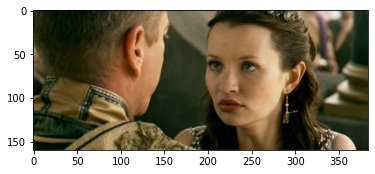

(1, 3, 160, 384)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


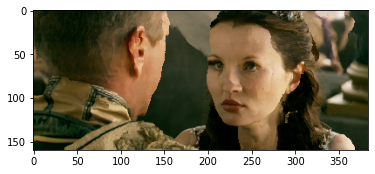

torch.Size([1, 3, 160, 384])


In [146]:
left, right = test(net, 'demo.jpg')

In [0]:
from gif import writeGif

#left = Image.fromarray(cv2.cvtColor(left, cv2.COLOR_BGR2RGB))
#right = Image.fromarray(cv2.cvtColor(right, cv2.COLOR_BGR2RGB))
writeGif('demo.gif', [left, right], duration=0.08)

In [0]:
# !wget 'https://github.com/n1ckfg/deep3d/blob/master/deep3d-symbol.json'
!unzip ./deep3d-0050.params.zip -d ./

Archive:  ./deep3d-0050.params.zip
  inflating: ./deep3d-0050.params    


In [0]:
# net.conv1_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv1_1_weight'].asnumpy(), device=device).float())
# net.conv1_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv1_1_bias'].asnumpy(), device=device).float())

# net.conv2_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv2_1_weight'].asnumpy(), device=device).float())
# net.conv2_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv2_1_bias'].asnumpy(), device=device).float())

# net.conv3_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv3_1_weight'].asnumpy(), device=device).float())
# net.conv3_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv3_1_bias'].asnumpy(), device=device).float())
# net.conv3_2.weight = torch.nn.Parameter(torch.tensor(model[1]['conv3_2_weight'].asnumpy(), device=device).float())
# net.conv3_2.bias = torch.nn.Parameter(torch.tensor(model[1]['conv3_2_bias'].asnumpy(), device=device).float())

# net.conv4_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv4_1_weight'].asnumpy(), device=device).float())
# net.conv4_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv4_1_bias'].asnumpy(), device=device).float())
# net.conv4_2.weight = torch.nn.Parameter(torch.tensor(model[1]['conv4_2_weight'].asnumpy(), device=device).float())
# net.conv4_2.bias = torch.nn.Parameter(torch.tensor(model[1]['conv4_2_bias'].asnumpy(), device=device).float())

# net.conv5_1.weight = torch.nn.Parameter(torch.tensor(model[1]['conv5_1_weight'].asnumpy(), device=device).float())
# net.conv5_1.bias = torch.nn.Parameter(torch.tensor(model[1]['conv5_1_bias'].asnumpy(), device=device).float())
# net.conv5_2.weight = torch.nn.Parameter(torch.tensor(model[1]['conv5_2_weight'].asnumpy(), device=device).float())
# net.conv5_2.bias = torch.nn.Parameter(torch.tensor(model[1]['conv5_2_bias'].asnumpy(), device=device).float())

# net.fc6.weight = torch.nn.Parameter(torch.tensor(model[1]['fc6_weight'].asnumpy(), device=device).float())
# net.fc6.bias = torch.nn.Parameter(torch.tensor(model[1]['fc6_bias'].asnumpy(), device=device).float())

# net.fc7.weight = torch.nn.Parameter(torch.tensor(model[1]['fc7_weight'].asnumpy(), device=device).float())
# net.fc7.bias = torch.nn.Parameter(torch.tensor(model[1]['fc7_bias'].asnumpy(), device=device).float())

# net.fc8.weight = torch.nn.Parameter(torch.tensor(model[1]['pred5_weight'].asnumpy(), device=device).float())
# net.fc8.bias = torch.nn.Parameter(torch.tensor(model[1]['pred5_bias'].asnumpy(), device=device).float())

# net.pred4.weight = torch.nn.Parameter(torch.tensor(model[1]['pred4_weight'].asnumpy(), device=device).float())
# net.pred4.bias = torch.nn.Parameter(torch.tensor(model[1]['pred4_bias'].asnumpy(), device=device).float())

# net.pred3.weight = torch.nn.Parameter(torch.tensor(model[1]['pred3_weight'].asnumpy(), device=device).float())
# net.pred3.bias = torch.nn.Parameter(torch.tensor(model[1]['pred3_bias'].asnumpy(), device=device).float())

# net.pred2.weight = torch.nn.Parameter(torch.tensor(model[1]['pred2_weight'].asnumpy(), device=device).float())
# net.pred2.bias = torch.nn.Parameter(torch.tensor(model[1]['pred2_bias'].asnumpy(), device=device).float())

# net.pred1.weight = torch.nn.Parameter(torch.tensor(model[1]['pred1_weight'].asnumpy(), device=device).float())
# net.pred1.bias = torch.nn.Parameter(torch.tensor(model[1]['pred1_bias'].asnumpy(), device=device).float())

# net.deconv_pred1.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred1_weight'].asnumpy(), device=device).float())
# net.deconv_pred1.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred1_bias'].asnumpy(), device=device).float())

# net.deconv_pred2.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred2_weight'].asnumpy(), device=device).float())
# net.deconv_pred2.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred2_bias'].asnumpy(), device=device).float())

# net.deconv_pred3.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred3_weight'].asnumpy(), device=device).float())
# net.deconv_pred3.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred3_bias'].asnumpy(), device=device).float())

# net.deconv_pred4.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred4_weight'].asnumpy(), device=device).float())
# net.deconv_pred4.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred4_bias'].asnumpy(), device=device).float())

# net.deconv_pred5.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred5_weight'].asnumpy(), device=device).float())
# net.deconv_pred5.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_pred5_bias'].asnumpy(), device=device).float())

# net.deconv_predup.weight = torch.nn.Parameter(torch.tensor(model[1]['deconv_predup_weight'].asnumpy(), device=device).float())
# net.deconv_predup.bias = torch.nn.Parameter(torch.tensor(model[1]['deconv_predup_bias'].asnumpy(), device=device).float())

# net.convolution0.weight = torch.nn.Parameter(torch.tensor(model[1]['convolution0_weight'].asnumpy(), device=device).float())
# net.convolution0.bias = torch.nn.Parameter(torch.tensor(model[1]['convolution0_bias'].asnumpy(), device=device).float())

# net.bn_pool1.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool1_gamma'].asnumpy(), device=device).float())
# net.bn_pool1.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool1_beta'].asnumpy(), device=device).float())
# net.bn_pool1.running_mean = torch.tensor(model[2]['bn_pool1_moving_mean'].asnumpy(), device=device).float()
# net.bn_pool1.running_var = torch.tensor(model[2]['bn_pool1_moving_inv_var'].asnumpy(), device=device).float()

# net.bn_pool2.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool2_gamma'].asnumpy(), device=device).float())
# net.bn_pool2.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool2_beta'].asnumpy(), device=device).float())
# net.bn_pool2.running_mean = torch.tensor(model[2]['bn_pool2_moving_mean'].asnumpy(), device=device).float()
# net.bn_pool2.running_var = torch.tensor(model[2]['bn_pool2_moving_inv_var'].asnumpy(), device=device).float()

# net.bn_pool3.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool3_gamma'].asnumpy(), device=device).float())
# net.bn_pool3.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool3_beta'].asnumpy(), device=device).float())
# net.bn_pool3.running_mean = torch.tensor(model[2]['bn_pool3_moving_mean'].asnumpy(), device=device).float()
# net.bn_pool3.running_var = torch.tensor(model[2]['bn_pool3_moving_inv_var'].asnumpy(), device=device).float()

# net.bn_pool4.weight = torch.nn.Parameter(torch.tensor(model[1]['bn_pool4_gamma'].asnumpy(), device=device).float())
# net.bn_pool4.bias = torch.nn.Parameter(torch.tensor(model[1]['bn_pool4_beta'].asnumpy(), device=device).float())
# net.bn_pool4.running_mean = torch.tensor(model[2]['bn_pool4_moving_mean'].asnumpy(), device=device).float()
# net.bn_pool4.running_var = torch.tensor(model[2]['bn_pool4_moving_inv_var'].asnumpy(), device=device).float()